# Defining and Training Models

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from numpy import log, sqrt, log2, ceil, exp
import matplotlib.pyplot as plt
from PreprocessingHelpers import CustomDataset
from Models.Models import Model1, Model2, Model3
from torch_lr_finder import LRFinder

## Load Data

In [2]:
with open("ProcessedData/train_sequences_padded_dataset.pkl", "rb") as file:
    train_sequences_padded_dataset = pickle.load(file)

with open("ProcessedData/vendors_tensor.pkl", "rb") as file:
    vendors_tensor = pickle.load(file)

In [3]:
# Define DataLoaders

batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_sequences_padded_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## Model Blueprint

Our model, creatively named Model1, is the prototype model which we define and test several variants of. At the highest level, our model is supposed to input a sequence of vendor labels the customer has ordered from, plus another vendor label. The output is a score. The higher the score, the more likely the customer is to order from that vendor next.

All of the relevant vendor information is stored within a lookup table based on the vendor id. A vendor id sent into the vendor lookup will result in a 1D tensor representing this vendor. The customer representation is simply the sum of the vendor representations it has recently ordered from. 

The customer and vendor representations are sparse due to the ptag and vtag features which have been one-hot encoded into $d_p$ and $d_v$ dimensional spaces, respectively. These features are independently embedded in $\textrm{ceil}(\textrm{log}_2(d_v))$ and $\textrm{ceil}(\textrm{log}_2(d_p))$ dimensional spaces, respectively via a simple dense layer. The embeddings are concatenated with the other features, and embedded again into customer and vendor embeddings using the same dimensionality reduction scheme. Finally, these embeddings are concatenated and sent through a few dense layers to output a score. Each layer in the network uses an exponential linear unit (ELU) activation function.

<p align="center">
  <img src="Imgs/Recommender1.png" width="1000"/>
</p>

## Margin Ranking Loss

To train our model, we will use a type of ranking loss function. A ranking loss takes as input the scores of a positive sample and a negative sample. A negative sample is simply a vendor which the customer has not recently ordered from. The output is
$$\textrm{loss}(x_+, x_-) = \textrm{max}(0, x_- + 1 - x_+)$$
The loss is $0$ when the positive sample is ranked at least the margin, which here is $1$, higher than or equal to the negative sample.

The idea for this is to train the model to score vendor $R_1$ higher than $R_2$ for a given customer if they prefer $R_1$ more than $R_2$.

In [4]:
def get_negative_samples(low_incl:int, high_excl:int, seqs, dtype=torch.long):
    neg_ids = torch.zeros(size=[seqs.shape[0]], dtype=dtype)
    for i in range(len(seqs)):
        neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        while neg_id in seqs[i]:
            neg_id = torch.randint(low=low_incl, high=high_excl, size=[1]).item()
        neg_ids[i] = neg_id
    return neg_ids


## Optimization

From a [blog post by fastai](https://www.fast.ai/2018/07/02/adam-weight-decay), an AdamW optimizer following a [1cycle learning rate scheduler](https://arxiv.org/abs/1708.07120) is the fastest way to train a neural network. 

From [pytorch-lr-finder docs](https://github.com/davidtvs/pytorch-lr-finder):

"The learning rate range test is a test that provides valuable information about the optimal learning rate. During a pre-training run, the learning rate is increased linearly or exponentially between two boundaries. The low initial learning rate allows the network to start converging and as the learning rate is increased it will eventually be too large and the network will diverge ...

"Typically, a good static learning rate can be found half-way on the descending loss curve ... 

"For cyclical learning rates (also detailed in Leslie Smith's paper) where the learning rate is cycled between two boundaries (start_lr, end_lr), the author advises the point at which the loss starts descending and the point at which the loss stops descending or becomes ragged for start_lr and end_lr respectively."

# Training

In [5]:
epochs = 200
print_every = 5
save_every = 10

iterations = epochs * len(train_loader)
print(f'Iterations: {iterations}')

Iterations: 385800


## Model1

### Model1_64
First dense layer has dimension 64.

In [13]:
# Tune LR scheduler

d_fc = 64
model = Model1(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

100%|██████████| 1000/1000 [00:07<00:00, 134.92it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.43E-04


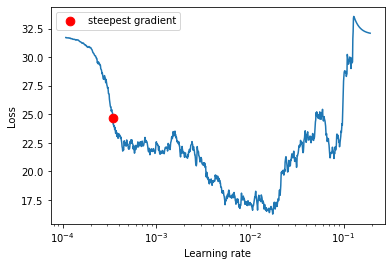

In [13]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader, end_lr=2e-1, num_iter=1000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [14]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [15]:
# Train Model1_64s

train_losses_1_64s = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)    

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    train_losses_1_64s.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model1_64s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:  \tsum(batch_losses) = {running_loss}')

PATH = f"Models/model1_64s_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/200]:	sum(batch_losses) = 29757.56547641754
Epoch [5/200]:	sum(batch_losses) = 20689.701577544212
Epoch [10/200]:	sum(batch_losses) = 19894.281579732895
Epoch [15/200]:	sum(batch_losses) = 19329.314561724663
Epoch [20/200]:	sum(batch_losses) = 19020.60701394081
Epoch [25/200]:	sum(batch_losses) = 18791.27143931389
Epoch [30/200]:	sum(batch_losses) = 18687.402283668518
Epoch [35/200]:	sum(batch_losses) = 18362.830173134804
Epoch [40/200]:	sum(batch_losses) = 18340.50474011898
Epoch [45/200]:	sum(batch_losses) = 18286.499306678772
Epoch [50/200]:	sum(batch_losses) = 17974.241465091705
Epoch [55/200]:	sum(batch_losses) = 18192.17642867565
Epoch [60/200]:	sum(batch_losses) = 18309.59603857994
Epoch    62: reducing learning rate of group 0 to 5.0000e-04.
Epoch [65/200]:	sum(batch_losses) = 17435.818981051445
Epoch [70/200]:	sum(batch_losses) = 17250.176556944847
Epoch [75/200]:	sum(batch_losses) = 17370.070516467094
Epoch [80/200]:	sum(batch_losses) = 17304.035081267357
Epoch [85/2

### Model1_128
First dense layer has dimension 128.

In [ ]:
# Tune LR scheduler

d_fc = 128
model = Model1(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
adamw = torch.optim.AdamW(model.parameters())

In [ ]:
lr_finder = LRFinder(model=model, optimizer=adamw, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [ ]:
# Train Model1_128s

train_losses_1_128s = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step()
    train_losses_1_128s.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model1_128s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:  \tsum(batch_losses) = {running_loss}')

PATH = f"Models/model1_128s_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

## Model 2

This model just adds dropout and batch norm to every non-embedding layer of Model 1.

In [8]:
# Tune LR scheduler

d_fc = 64
model = Model2(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)


100%|██████████| 500/500 [00:03<00:00, 127.45it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.16E-02


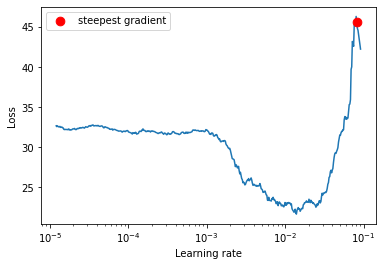

In [9]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=500)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [12]:
3e-2 / 3e-3

10.0

In [10]:
epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-2, epochs=epochs, steps_per_epoch=len(train_loader), pct_start=0.3, div_factor=5)

In [11]:
# Train Model2s

train_losses_2s = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs=c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Calculate gradients
        batch_loss.backward()

        # Update parameters
        optimizer.step()
        scheduler.step()

        # Reset gradients
        optimizer.zero_grad()
    train_losses_2s.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]:\tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model2s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:  \tsum(batch_losses) = {running_loss}')

PATH = f"Models/model2s_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/100]:	sum(batch_losses) = 43158.924112319946
Epoch [5/100]:	sum(batch_losses) = 31243.122982025146
Epoch [10/100]:	sum(batch_losses) = 31351.658428430557
Epoch [15/100]:	sum(batch_losses) = 31737.354941368103
Epoch [20/100]:	sum(batch_losses) = 32636.565944194794
Epoch [25/100]:	sum(batch_losses) = 33697.40887117386
Epoch [30/100]:	sum(batch_losses) = 34269.0380218029
Epoch [35/100]:	sum(batch_losses) = 39112.63276338577
Epoch [40/100]:	sum(batch_losses) = 33929.08266687393
Epoch [45/100]:	sum(batch_losses) = 34825.95917844772
Epoch [50/100]:	sum(batch_losses) = 38615.45236301422
Epoch [55/100]:	sum(batch_losses) = 34133.12525892258
Epoch [60/100]:	sum(batch_losses) = 32584.111036777496
Epoch [65/100]:	sum(batch_losses) = 31807.789583206177
Epoch [70/100]:	sum(batch_losses) = 31354.02748155594
Epoch [75/100]:	sum(batch_losses) = 30406.962388038635
Epoch [80/100]:	sum(batch_losses) = 29793.210347652435
Epoch [85/100]:	sum(batch_losses) = 29245.65392112732
Epoch [90/100]:	sum(ba

## Model 3

The embedding layers for the customer and vendor portions are now shared. 

In [9]:
# Tune LR scheduler

d_fc = 64
model = Model3(vendors=vendors_tensor, d_fc=d_fc)
mr_loss = nn.MarginRankingLoss(margin=1.0, reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

100%|██████████| 5000/5000 [00:36<00:00, 138.73it/s]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.68E-02


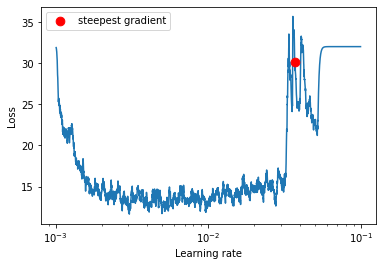

In [12]:
lr_finder = LRFinder(model=model, optimizer=optimizer, criterion=mr_loss, device="cpu")
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=5000)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [10]:
epochs = 400
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, verbose=True)

In [11]:
# Train Model3s

train_losses_3s = []

for epoch in range(epochs):
    running_loss = 0.0
    for i, (c_seq, v_id) in enumerate(train_loader):

        # Generate negative samples
        neg_v_id = get_negative_samples(low_incl=1, high_excl=101, seqs = c_seq)

        # Get scores
        pos_pred = model.forward(c_seq, v_id)
        neg_pred = model.forward(c_seq, neg_v_id)

        # Compute loss
        mr_loss_target = torch.ones(pos_pred.size())
        batch_loss = mr_loss(pos_pred, neg_pred, mr_loss_target)
        running_loss += batch_loss.item()

        # Update parameters
        batch_loss.backward()
        optimizer.step()

        # Reset gradients
        optimizer.zero_grad()
    scheduler.step(running_loss)
    train_losses3.append(running_loss)
    
    # Save states and print losses
    if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{epochs}]: \tsum(batch_losses) = {running_loss}')

    if epoch % save_every == 0:
        PATH = f"Models/model3s_epoch{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': mr_loss,
            }, PATH)

# Save final states and print final losses
print(f'Epoch [{epochs}/{epochs}]:  \tsum(batch_losses) = {running_loss}')

PATH = f"Models/model3s_epoch{epochs}.pt"
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': mr_loss,
    }, PATH)

print('Done!')

Epoch [0/400]: 	sum(batch_losses) = 29120.02059483528
Epoch [5/400]: 	sum(batch_losses) = 20344.671631097794
Epoch [10/400]: 	sum(batch_losses) = 19884.660190701485
Epoch [15/400]: 	sum(batch_losses) = 19121.96692842245
Epoch [20/400]: 	sum(batch_losses) = 18940.414473056793
Epoch [25/400]: 	sum(batch_losses) = 18823.748360574245
Epoch [30/400]: 	sum(batch_losses) = 18754.84560275078
Epoch [35/400]: 	sum(batch_losses) = 18522.975008785725
Epoch [40/400]: 	sum(batch_losses) = 18375.935994386673
Epoch [45/400]: 	sum(batch_losses) = 18287.175960063934
Epoch [50/400]: 	sum(batch_losses) = 18274.562456905842
Epoch [55/400]: 	sum(batch_losses) = 18220.755725085735
Epoch [60/400]: 	sum(batch_losses) = 18126.119380414486
Epoch [65/400]: 	sum(batch_losses) = 18125.11615473032
Epoch    71: reducing learning rate of group 0 to 1.0000e-03.
Epoch [70/400]: 	sum(batch_losses) = 18211.24489814043
Epoch [75/400]: 	sum(batch_losses) = 17343.430123806
Epoch [80/400]: 	sum(batch_losses) = 17499.287898719

# Check

In [ ]:
print(f'num batches: {len(train_losses1)}')
print(f'batches per epoch: {len(train_losses1) // epochs}')

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(range(len(train_losses1)), train_losses1, label="Model1")
plt.plot(range(len(train_losses2)), train_losses2, label="Model2")
plt.plot(range(len(train_losses3)), train_losses3, label="Model3")
plt.xlabel('Batch #')
plt.ylabel('Batch Loss')
plt.legend()
plt.show()

In [ ]:
with open("ProcessedData/test_sequences_padded_dataset.pkl", "rb") as file:
    test_sequences_padded_dataset = pickle.load(file)

test_loader = torch.utils.data.DataLoader(test_sequences_padded_dataset, batch_size=1)

seq = iter(test_loader).next()[0]
print(seq)
seq = seq.view(1, -1)

In [ ]:
model.eval()

seq = torch.tensor([[28, 28, 28, 28, 28]])

y = torch.ones([100, 1], dtype=torch.long)      # 100 vendors
seq_dupe = y @ seq                              # 100 x 5 matrix
v_ids = torch.arange(start=1, end=101, dtype=torch.long)
rankings = model.forward(c_seq=seq_dupe, v_id=v_ids).view(-1)    
top_k = torch.topk(rankings, 5)[1][:5]          # Essentially argmax for top k
top_k = top_k + 1

print(rankings.sort(descending=True))
print(len(rankings.tolist()))
print(top_k)

In [ ]:
top_k + 1